In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:

#reading in an image
image = mpimg.imread('output/video_static1.jpg')
img1_original = image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


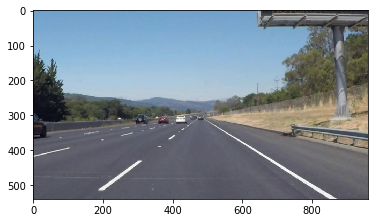

In [3]:
#printing out some stats and plotting
print('This image is:', type(img1_original), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


In [4]:
def original_to_grayscale(img):
    # Converts an image to grayscale

    print('this image is: ', type(img), 'with dimensions: ', img.shape)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Grayscale conversion

def Gaussian_smoothing(img, kernel_size):
    # Apply Gaussian smoothing (even though it's already part of cv2.Canny – which we use later)
    # Note that cv2.Canny uses a 5x5 filter
    # kernel_size must be an odd number, else it throws an exception

    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def Canny_edge_detection(img, low_threshold, high_threshold):
    # Apply a Canny edge detection.
    # Note that high:low threshold should ideally be ~2.5:1

    return cv2.Canny(img, low_threshold, high_threshold)

def Hough_transform(img,vertices,rho,theta,threshold,min_line_len, max_line_gap):
    # Hough transformation to find the lines within a region of interest
    # Finds the lines that are at least min_line_len long and separated by max_line_gap pixels
    # img = result of canny edge detection

    # STEP 1: Constrain to a region of interest
    img_black = np.zeros_like(img)
    mask      = cv2.fillPoly(img_black, vertices, 255)

    # STEP 2: Perform Hough Transformation and return the lines within the region of interest
    region_of_interest = cv2.bitwise_and(img,mask)
    return cv2.HoughLinesP(region_of_interest, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)


def draw_lines(lines,img):
    # Draw the lines on a new image, which will be overlayed with the original
    # Each line in lines is a 4-tuple of int32 coordinates (the output from the Hough Transformation)

    img_copy = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)

    # Cycle through lines and draw them in two different colors
    i = 0
    colors = [[255, 0, 0], [0, 255, 0]]

    # Draw each line
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color=colors[i], thickness=3)
        i += 1

    return img_copy


def gradients(lines):
    # Finds the gradients of the lines on an image

    grad = np.zeros(len(lines), dtype= np.float32)
    j = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            grad[j] =  (y2 -y1)/(x2 - x1)
            j+=1

    return grad


def find_lane_markings(lines,vertices):
    # Find the start and end points of the left and right lane markers.
    # This returns two 4-tuples, each defining the start and end points of the respective lane.

    # Note that if (x,y) are CARTESIAN coordinates of an image and [a,b] are array coordinates of the same image, then
    # 1) x = b, 2) y = a, and 3) y increases => b decreases.

    # Therefore, the left lane lines will have a NEGATIVE gradient in array coordinates,
    # while the right lane lines will have POSITIVE gradients.


    # Define lane marking lines
    lane_markings = np.zeros((2, 1, 4), dtype=np.float32)

    # STEP 1: Get the gradients of the lines
    grad = gradients(lines)

    # STEP 2: Itentidy which gradients are associated with left/right lanes.
    index_right = np.asarray([i for i, j in enumerate(grad) if j >= 0])
    index_left = np.asarray([i for i, j in enumerate(grad) if j < 0])  # NOTE left line has NEGATIVE gradient (as y increases in the downward direction)

    # STEP 3: Split the lines into left and right lines
    left_lines = lines[index_left]
    right_lines = lines[index_right]

    # STEP 4: Draw a line from the closest to the farthest points in the LEFT lane, and extrapolate to the ends of the region of
    # using a simple y = mx + c straight line equation

    # Find the closest point to car
    j = np.argmax(left_lines[:, 0, 1]) # Finds the highest number from [,:,,] i.e. the closest point to the car
    x0 = left_lines[j, 0, 0]
    y0 = left_lines[j, 0, 1]

    # Find the furthest point from the car
    i = np.argmin(left_lines[:,0,3]) # Finds the lowest number form [,,,:] i.e. the closest point to the top edge
    x1 = left_lines[i,0,2]
    y1 = left_lines[i,0,3]

    #  Find the gradient
    left_grad = (y1-y0)/(x1-x0)

    # Intersection point at upper edge
    mask_top = vertices[0, 1, 1]  # This is the top of the mask
    xa = x0 - (y0 - mask_top) / left_grad
    ya = mask_top

    # Intersection point at lower edge
    xb = x0 + (540 - y0) / left_grad
    yb = 540

    lane_markings[0, 0, :] = [xb, yb, xa, ya]

    # STEP 5: Draw a line from the closest to the farthest points in the RIGHT lane, and extrapolate to the ends of the region of
    # using a simple y = mx + c straight line equation

    # Find the closest point to car
    j = np.argmax(right_lines[:, 0, 3])
    x0 = right_lines[j, 0, 2]
    y0 = right_lines[j, 0, 3]

    # Find the furthest point from the car
    i  = np.argmin(right_lines[:,0,1])
    x1 = right_lines[i,0,0]
    y1 = right_lines[i,0,1]

    # Find the gradient
    right_grad = (y1 - y0) / (x1 - x0)

    # Intersection point at upper edge
    mask_top = vertices[0, 1, 1]  # This is the top of the mask
    xa = x0 - (y0 - mask_top) / right_grad
    ya = mask_top

    # Intersection point at lower edge
    xb = x0 + (540 - y0) / right_grad
    yb = 540

    lane_markings[1, 0, :] = [xa, ya, xb, yb]

    return lane_markings


In [5]:
# STEP 1: Convert to gray scale
img1 = original_to_grayscale(image)


# STEP 2: Apply Gaussian smoothing
kernel_size = 3 # Must be an odd number
img1b = Gaussian_smoothing(img1,kernel_size = kernel_size)

# STEP 3: Canny edge detection
low_threshold  = 105
high_threshold = 130
img1c = Canny_edge_detection(img1b,low_threshold = low_threshold, high_threshold = high_threshold)

# STEP 4: Define region of interest for lane detection
vertices = np.array([[[0, 540],
                      [450, 320],
                      [500, 320],
                      [960, 540]]], dtype=np.int32)

# STEP 5: Perform a Hough Transformation to find the (broken) lines
lines = Hough_transform(img1c,
                        vertices,
                        rho = 5,            # rho-resolution in Hough space
                        theta = 0.01,       # In radians (~pi/180)
                        threshold = 80,     # Minimum number of line-crossings in a cell in the (rho,theta) grid (Hough-space) to qualify as an output point (or line, in cartesian-space)
                        min_line_len = 2,   # Minimum length of line in pixels
                        max_line_gap = 1)

# STEP 6: Find the start and end coordinates of the left and right lanes
lane_markings = find_lane_markings(lines,vertices)

# STEP 7: Draw the lane markings (black image with two lines)
img1f  = draw_lines(lane_markings ,image)

# STEP 8: Overlay the original image with the drawn lines
alpha = 0.4
beta  = 1 - alpha
gamma = 0
img_final = cv2.addWeighted(image, alpha, img1f, beta, gamma)

print(img_final.shape)


# then save them to the test_images directory.

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
(540, 960, 3)


In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):

    # The full process of identifying and highlighting the left and right lane markings.
    # INPUT:
    # image = a three-channel image
    # RETURNS:
    # image_final = the darkened original image with highlighted left and right lane markings

    # STEP 1: Convert to gray scale
    img1 = original_to_grayscale(image)
  


    # STEP 2: Apply Gaussian smoothing
    kernel_size = 3 # Must be an odd number
    img1b = Gaussian_smoothing(img1,kernel_size = kernel_size)
     
    # STEP 3: Canny edge detection
    low_threshold  = 105
    high_threshold = 130
    img1c = Canny_edge_detection(img1b,low_threshold = low_threshold, high_threshold = high_threshold)

    # STEP 4: Define region of interest for lane detection
    vertices = np.array([[[0, 540],
                          [450, 315],
                          [500, 315],
                          [960, 540]]], dtype=np.int32)

    # STEP 5: Perform a Hough Transformation to find the (broken) lines
    lines = Hough_transform(img1c,
                            vertices,
                            rho = 5,            # rho-resolution in Hough space
                            theta = 0.01,       # In radians (~pi/180)
                            threshold = 80,     # Minimum number of line-crossings in a cell in the (rho,theta) grid (Hough-space) to qualify as an output point (or line, in cartesian-space)
                            min_line_len = 2,   # Minimum length of line in pixels
                            max_line_gap = 1)

    # STEP 6: Find the start and end coordinates of the left and right lanes
    lane_markings = find_lane_markings(lines,vertices)

    # STEP 7: Draw the lane markings (black image with two lines)
    img1f  = draw_lines(lane_markings ,image)

    # STEP 8: Overlay the original image with the drawn lines
    alpha = 0.4
    beta  = 1 - alpha
    gamma = 0
    img_final = cv2.addWeighted(image, alpha, img1f, beta, gamma)

    return img_final


In [8]:
white_output = 'solidWhiteRight_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("solidWhiteRight.mp4")
# clip1.save_frame("output/video_static2.jpg",5)
# clip1.save_frame("output/video_static3.jpg",5.5)
# clip1.save_frame("output/video_static4.jpg",6)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
[MoviePy] >>>> Building video solidWhiteRight_output.mp4
[MoviePy] Writing video solidWhiteRight_output.mp4


  5%|▍         | 10/222 [00:00<00:02, 94.05it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 

 10%|█         | 23/222 [00:00<00:03, 61.51it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 14%|█▍        | 32/222 [00:00<00:02, 67.31it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 19%|█▉        | 43/222 [00:00<00:02, 75.53it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 

 26%|██▌       | 57/222 [00:00<00:02, 67.55it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> 

 29%|██▉       | 64/222 [00:00<00:02, 60.84it/s]

with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 32%|███▏      | 71/222 [00:01<00:02, 59.65it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is: 

 35%|███▍      | 77/222 [00:01<00:02, 58.51it/s]

 <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 37%|███▋      | 83/222 [00:01<00:02, 58.54it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 40%|████      | 89/222 [00:01<00:02, 52.90it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 43%|████▎     | 95/222 [00:01<00:02, 52.85it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 45%|████▌     | 101/222 [00:01<00:02, 53.73it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 49%|████▊     | 108/222 [00:01<00:02, 56.31it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 51%|█████▏    | 114/222 [00:01<00:01, 56.56it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 55%|█████▍    | 121/222 [00:01<00:01, 58.42it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 57%|█████▋    | 127/222 [00:02<00:01, 56.29it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 60%|█████▉    | 133/222 [00:02<00:01, 54.68it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  

 63%|██████▎   | 139/222 [00:02<00:01, 54.00it/s]

(540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 65%|██████▌   | 145/222 [00:02<00:01, 51.64it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 68%|██████▊   | 151/222 [00:02<00:01, 50.80it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 71%|███████   | 157/222 [00:02<00:01, 51.93it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 74%|███████▍  | 164/222 [00:02<00:01, 54.65it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 77%|███████▋  | 170/222 [00:02<00:00, 55.48it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 79%|███████▉  | 176/222 [00:02<00:00, 56.75it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 82%|████████▏ | 182/222 [00:03<00:00, 56.76it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 85%|████████▍ | 188/222 [00:03<00:00, 54.61it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 87%|████████▋ | 194/222 [00:03<00:00, 53.53it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 90%|█████████ | 200/222 [00:03<00:00, 50.74it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


 93%|█████████▎| 206/222 [00:03<00:00, 52.02it/s]

this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is: 

 96%|█████████▌| 213/222 [00:03<00:00, 55.15it/s]

 <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


100%|█████████▉| 221/222 [00:03<00:00, 57.77it/s]


this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
this image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight_output.mp4 

CPU times: user 3.15 s, sys: 1.11 s, total: 4.26 s
Wall time: 4.29 s


In [9]:
# im2 = mpimg.imread("output/video_static2.jpg")
# im2a = process_image(im2)
# plt.imsave("output/video_static1withlines.jpg", im2a)
# im3 = mpimg.imread("output/video_static3.jpg")
# im3a = process_image(im3)
# plt.imsave("output/video_static1withlines.jpg", im3a)
# im4 = mpimg.imread("output/video_static4.jpg")
# im4a = process_image(im4)
# plt.imsave("output/video_static1withlines.jpg", im4a)


In [10]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))